In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

In [2]:
xls = pd.ExcelFile('data_set_6.5.xlsx')
rt = pd.read_excel(xls, 'rider_trips')
dt = pd.read_excel(xls, 'driver_trips')

In [3]:
# duplicated trip_id
rt.drop(rt[rt['trip_id'] == '94a1-82d8'].index, inplace = True)
dt.drop(dt[dt['trip_id'] == '94a1-82d8'].index, inplace = True)

In [4]:
# inner join the two tables
trips = dt.merge(rt, how = 'inner', on = ['trip_id', 'trip_status', 'request_time', 'surge_multiplier', 'start_geo', 'end_geo'])

In [5]:
# drop where ETA and ATA are both NaN
print((trips['actual_time_to_arrival'].isnull() & trips['estimated_time_to_arrival'].isnull()).sum())
trips = trips[~(trips['actual_time_to_arrival'].isnull() & trips['estimated_time_to_arrival'].isnull())]

2354


In [6]:
# drop failed or unfullfiled, not our interests here
print(((trips['trip_status'] == 'failed') | (trips['trip_status'] == 'unfulfilled')).sum())
trips = trips[(trips['trip_status'] != 'failed') & (trips['trip_status'] != 'unfulfilled')]

20


In [7]:
# binarize trip_status
trips['cancel'] = trips['trip_status'].map({'completed':0, 'rider_canceled':1})
trips.drop('trip_status', axis = 1, inplace = True)

2.833333333

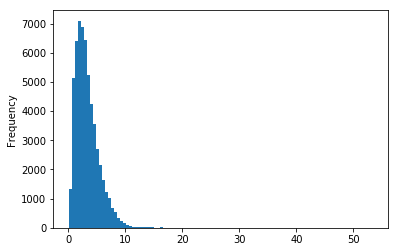

In [8]:
# the distribution of ETA
trips['estimated_time_to_arrival'].plot.hist(bins = 100)
trips['estimated_time_to_arrival'].median()

2.816666667

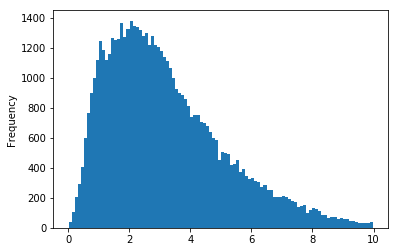

In [9]:
# zoom in
trips[trips['estimated_time_to_arrival'] < 10]['estimated_time_to_arrival'].plot.hist(bins = 100)
trips[trips['estimated_time_to_arrival'] < 10]['estimated_time_to_arrival'].median()
# looks like an exponential distribution

1.966666667

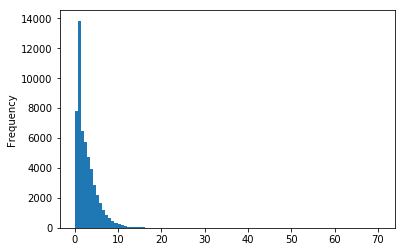

In [10]:
# the distribution of actual time to arrival (ATA)
trips['actual_time_to_arrival'].plot.hist(bins = 100)
trips['actual_time_to_arrival'].median()

1.916666667

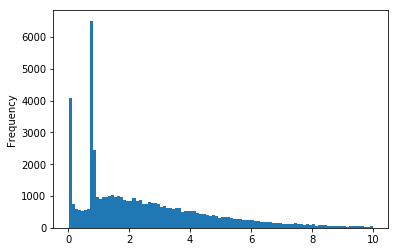

In [11]:
# zoom in
trips[trips['actual_time_to_arrival'] < 10]['actual_time_to_arrival'].plot.hist(bins = 100)
trips[trips['actual_time_to_arrival'] < 10]['actual_time_to_arrival'].median()

In [12]:
# metric: |ATA - ETA|
trips['err'] = (trips['actual_time_to_arrival'] - trips['estimated_time_to_arrival']).abs()

0.9000000000000004

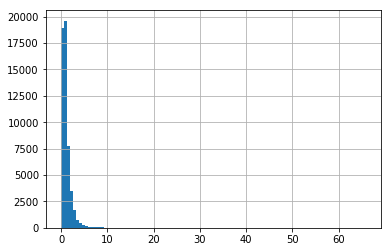

In [13]:
trips['err'].hist(bins = 100)
trips['err'].median()

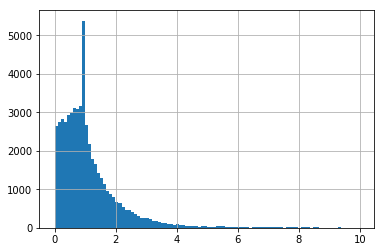

In [14]:
# zoom in
trips[trips['err'] < 10]['err'].hist(bins = 100)

In [15]:
# 4 weeks of data
trips['request_time'].describe()

count                   57478
unique                  26603
top       2012-04-27 19:26:00
freq                       13
first     2012-04-09 00:00:00
last      2012-05-06 23:55:00
Name: request_time, dtype: object

In [16]:
# plot group by weekday and hour
trips['weekday'] = trips['request_time'].dt.weekday
trips['hour'] = trips['request_time'].dt.hour
trips['week'] = trips['request_time'].dt.week

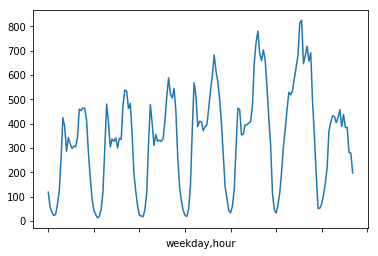

In [17]:
# n trips across the week
trips.groupby(['weekday', 'hour'])['trip_id'].count().plot()

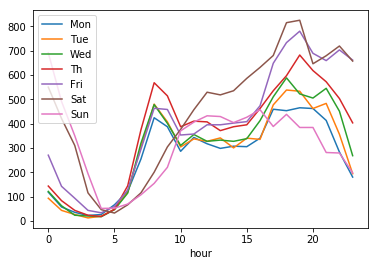

In [18]:
# overlayed
weekdays = pd.DataFrame()
weekdays['Mon'] = trips[trips['weekday'] == 0].groupby('hour')['trip_id'].count()
weekdays['Tue'] = trips[trips['weekday'] == 1].groupby('hour')['trip_id'].count()
weekdays['Wed'] = trips[trips['weekday'] == 2].groupby('hour')['trip_id'].count()
weekdays['Th'] = trips[trips['weekday'] == 3].groupby('hour')['trip_id'].count()
weekdays['Fri'] = trips[trips['weekday'] == 4].groupby('hour')['trip_id'].count()
weekdays['Sat'] = trips[trips['weekday'] == 5].groupby('hour')['trip_id'].count()
weekdays['Sun'] = trips[trips['weekday'] == 6].groupby('hour')['trip_id'].count()
weekdays.plot()

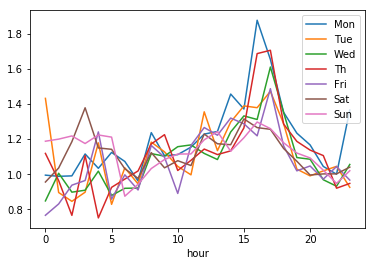

In [19]:
# mean error by time
err = pd.DataFrame()
err['Mon'] = trips[trips['weekday'] == 0].groupby('hour')['err'].mean()
err['Tue'] = trips[trips['weekday'] == 1].groupby('hour')['err'].mean()
err['Wed'] = trips[trips['weekday'] == 2].groupby('hour')['err'].mean()
err['Th'] = trips[trips['weekday'] == 3].groupby('hour')['err'].mean()
err['Fri'] = trips[trips['weekday'] == 4].groupby('hour')['err'].mean()
err['Sat'] = trips[trips['weekday'] == 5].groupby('hour')['err'].mean()
err['Sun'] = trips[trips['weekday'] == 6].groupby('hour')['err'].mean()
err.plot()

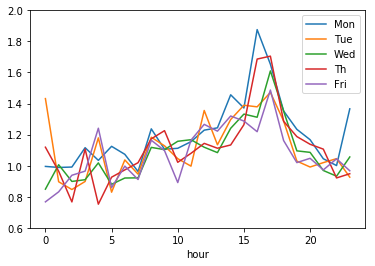

In [20]:
# weekdays
err[['Mon','Tue','Wed','Th','Fri']].plot(ylim = (.6, 2))

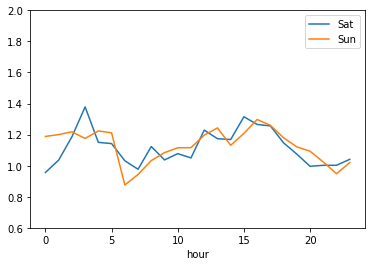

In [21]:
# weekends
err[['Sat', 'Sun']].plot(ylim = (.6, 2))

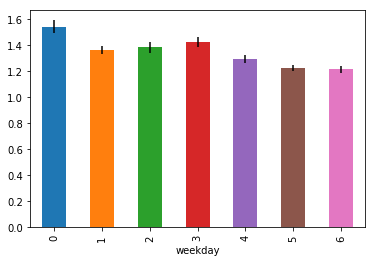

In [22]:
# take the rush hour 1pm - 7pm out
rush = trips[(trips['hour'] > 13) & (trips['hour'] < 19)]
err_dow = pd.DataFrame()
err_dow['mean'] = rush.groupby('weekday')['err'].mean()
err_dow['sem'] = rush.groupby('weekday')['err'].sem()
# err by day of the week, errorbar = SEM
err_dow['mean'].plot.bar(yerr=err_dow['sem'])

In [23]:
# ANOVA test for day of week effect?
mon = rush[rush['weekday'] == 0]['err'].dropna().values
tue = rush[rush['weekday'] == 1]['err'].dropna().values
wed = rush[rush['weekday'] == 2]['err'].dropna().values
th = rush[rush['weekday'] == 3]['err'].dropna().values
fri = rush[rush['weekday'] == 4]['err'].dropna().values
sat = rush[rush['weekday'] == 5]['err'].dropna().values
sun = rush[rush['weekday'] == 6]['err'].dropna().values
stats.f_oneway(mon, tue, wed, th, fri, sat, sun)

F_onewayResult(statistic=10.970308127614148, pvalue=3.122360479349132e-12)

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# which day?
tukeydata = rush['err'].dropna()
group = rush[rush['err'].notnull()]['weekday']
print(pairwise_tukeyhsd(tukeydata, group))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.1756  -0.3325 -0.0186  True 
  0      2    -0.1572  -0.3111 -0.0033  True 
  0      3    -0.1174  -0.2686  0.0339 False 
  0      4     -0.248  -0.3953 -0.1007  True 
  0      5    -0.3152  -0.4565  -0.174  True 
  0      6    -0.3262  -0.4807 -0.1716  True 
  1      2     0.0184  -0.1321  0.1689 False 
  1      3     0.0582  -0.0896  0.206  False 
  1      4    -0.0724  -0.2161  0.0713 False 
  1      5    -0.1397  -0.2772 -0.0022  True 
  1      6    -0.1506  -0.3017  0.0006 False 
  2      3     0.0398  -0.1047  0.1843 False 
  2      4    -0.0908  -0.2312  0.0496 False 
  2      5    -0.1581  -0.2921 -0.0241  True 
  2      6     -0.169  -0.3169  -0.021  True 
  3      4    -0.1306  -0.2681  0.0069 False 
  3      5    -0.1979  -0.3288 -0.0669  True 
  3      6    -0.2088   -0.354 -0.0635  True 
  4      5    -0.0672  -0.193

In [25]:
x = rush[rush['weekday'] < 5]['err'].dropna()
y = rush[rush['weekday'] > 4]['err'].dropna()
stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=24130768.5, pvalue=1.0870660706325567e-05)

In [26]:
stats.ttest_ind(x,y,equal_var = False)

Ttest_indResult(statistic=7.094356183081703, pvalue=1.3643019146396703e-12)

In [27]:
nonrush = trips[(trips['hour'] < 13) | (trips['hour'] > 19)]

In [28]:
x = rush['err'].dropna()
y = nonrush['err'].dropna()
stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=212056003.5, pvalue=1.340708785538466e-100)

In [29]:
stats.ttest_ind(x,y,equal_var = False)

Ttest_indResult(statistic=18.28297439121605, pvalue=3.583113847783947e-74)

In [30]:
crate = pd.DataFrame()
crate['Mon'] = trips[trips['weekday'] == 0].groupby('hour')['cancel'].mean()
crate['Tue'] = trips[trips['weekday'] == 1].groupby('hour')['cancel'].mean()
crate['Wed'] = trips[trips['weekday'] == 2].groupby('hour')['cancel'].mean()
crate['Th'] = trips[trips['weekday'] == 3].groupby('hour')['cancel'].mean()
crate['Fri'] = trips[trips['weekday'] == 4].groupby('hour')['cancel'].mean()
crate['Sat'] = trips[trips['weekday'] == 5].groupby('hour')['cancel'].mean()
crate['Sun'] = trips[trips['weekday'] == 6].groupby('hour')['cancel'].mean()

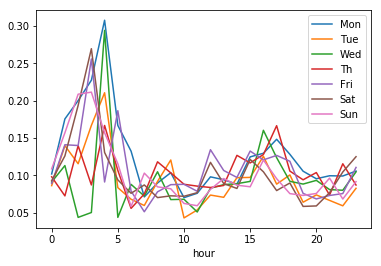

In [31]:
crate.plot()

In [32]:
trips.dropna()['cancel'].mean()

0.03418468317090475

In [33]:
trips['ebin'] = pd.qcut(trips['err'], q = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

In [34]:
#trips['ebin'] = pd.qcut(trips['err'], q = [0,.2,.4,.6,.8,1])

In [35]:
crate_ebin = pd.DataFrame()
crate_ebin['mean'] = trips.groupby('ebin')['cancel'].mean()
crate_ebin['n'] = trips.groupby('ebin')['cancel'].count()
crate_ebin['ci'] = (crate_ebin['mean'] * (1-crate_ebin['mean']) / crate_ebin['n'])**.5 * 1.96

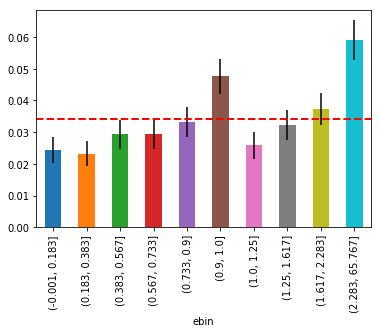

In [36]:
fig, ax = plt.subplots(1)
crate_ebin['mean'].plot.bar(ax = ax, yerr=crate_ebin['ci'])
ax.axhline(y = trips.dropna()['cancel'].mean(), xmin=0, xmax=1, color='r', linestyle='--', lw=2)

In [37]:
# group trips by origin
aa = trips[trips['start_geo'] == 'Allen Abby']
bb = trips[trips['start_geo'] == 'Blair Bend']
cc = trips[trips['start_geo'] == 'Chelsea Court']
dd = trips[trips['start_geo'] == 'Blair Bend']

In [38]:
trips.groupby('start_geo')['cancel'].mean()

start_geo
Allen Abby       0.082249
Blair Bend       0.107334
Chelsea Court    0.100586
Daisy Drive      0.084278
Name: cancel, dtype: float64

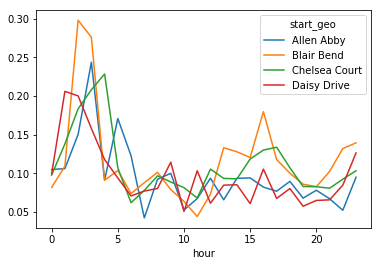

In [39]:
trips.groupby(['start_geo', 'hour'])['cancel'].mean().unstack(level = 0).plot()

In [40]:
def look_bin(data):
    m = data.dropna()['cancel'].mean()
    #data['ebin'] = pd.qcut(data['err'], q = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    crate_ebin = pd.DataFrame()
    crate_ebin['mean'] = data.groupby('ebin')['cancel'].mean()
    #crate_ebin['mean'].plot.bar()
    crate_ebin['n'] = data.groupby('ebin')['cancel'].count()
    crate_ebin['ci'] = (crate_ebin['mean'] * (1-crate_ebin['mean']) / crate_ebin['n'])**.5 * 1.96
    fig, ax = plt.subplots(1)
    crate_ebin['mean'].plot.bar(ax = ax, yerr=crate_ebin['ci'])
    ax.axhline(y = m, xmin=0, xmax=1, color='r', linestyle='--', lw=2)

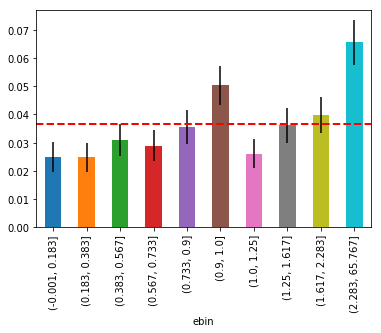

In [41]:
look_bin(cc)

In [42]:
import lightgbm as lgb

In [43]:
trips.dropna(inplace = True)

In [45]:
trips.drop(['cancel', 'err', 'week','ebin'], axis = 1, inplace = True)

In [46]:
dri = pd.read_excel(xls, 'driver_data')
rid = pd.read_excel(xls, 'rider_data')
city = pd.read_excel(xls, 'city_metrics')

In [47]:
dri.drop(5068, inplace = True)
dri['fare_rate'] = dri['lifetime_fares']/dri['lifetime_completed_trips']
dri.drop(['lifetime_fares', 'first_completed_trip'], axis = 1, inplace = True)

In [48]:
trips = trips.merge(dri, on = 'driver_id', how = 'left')

In [49]:
rid['rider_rate'] = rid['lifetime_payments'] / rid['lifetime_trips']
rid.drop(['first_completed_trip', 'first_trip_city_id', 'lifetime_payments'], axis = 1, inplace = True)

In [51]:
trips = trips.merge(rid, on = 'rider_id', how = 'left')

In [53]:
city['date'] = city['timestamp'].dt.date
city['hour'] = city['timestamp'].dt.hour
city.drop('timestamp', axis = 1, inplace = True)
trips['date'] = trips['request_time'].dt.date

In [55]:
trips = trips.merge(city, on = ['date', 'hour'], how = 'left')

In [57]:
df = trips.drop(['date', 'trip_id','rider_id', 'driver_id', 'request_time'], axis = 1)

In [58]:
geo_dict = {'Allen Abby':0, 'Blair Bend': 1, 'Chelsea Court': 2, 'Daisy Drive':3}

In [59]:
df['start_geo'] = df['start_geo'].map(geo_dict)

In [60]:
df['end_geo'] = df['end_geo'].map(geo_dict)

In [61]:
y = df['actual_time_to_arrival']

In [62]:
X = df.drop('actual_time_to_arrival', axis = 1)

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state=0)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size = 0.5, random_state=0)

In [67]:
params = {
    'num_leaves': 51,
    'objective': 'regression',
    'min_data_in_leaf': 500,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l1',
    'num_threads': 11
}
MAX_ROUNDS = 2000
val_pred = []
test_pred = []
cate_vars = ['start_geo', 'end_geo', 'weekday', 'hour']

In [68]:
dtrain = lgb.Dataset(Xtrain, label = ytrain, categorical_feature=cate_vars)

In [69]:
dval = lgb.Dataset(Xval, label = yval, reference=dtrain, categorical_feature=cate_vars)

In [70]:
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, valid_sets=[dtrain, dval],
                    early_stopping_rounds=50, verbose_eval=50)

/home/tselab/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/tselab/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l1: 1.46839	valid_1's l1: 1.45298
[100]	training's l1: 1.24293	valid_1's l1: 1.23737
[150]	training's l1: 1.1024	valid_1's l1: 1.10823
[200]	training's l1: 1.02841	valid_1's l1: 1.03859
[250]	training's l1: 0.99407	valid_1's l1: 1.00801
[300]	training's l1: 0.975626	valid_1's l1: 0.991621
[350]	training's l1: 0.965737	valid_1's l1: 0.982984
[400]	training's l1: 0.958653	valid_1's l1: 0.977454
[450]	training's l1: 0.953225	valid_1's l1: 0.973575
[500]	training's l1: 0.948718	valid_1's l1: 0.971324
[550]	training's l1: 0.944707	valid_1's l1: 0.969388
[600]	training's l1: 0.941434	valid_1's l1: 0.968213
[650]	training's l1: 0.93856	valid_1's l1: 0.967505
[700]	training's l1: 0.935962	valid_1's l1: 0.967369
[750]	training's l1: 0.933338	valid_1's l1: 0.967202
[800]	training's l1: 0.930714	valid_1's l1: 0.96656
Early stopping, best iteration is:
[792]	training's l1: 0.931112	valid_1's l1: 0.966533


In [71]:
print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(Xtrain.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))

estimated_time_to_arrival: 7051650.12
driver payout: 182607.65
hour: 165992.34
lifetime_trips: 159029.02
surge_multiplier: 97708.08
rider_rate: 66836.77
rider_payment: 64638.22
lifetime_rating: 63498.11
mean_surge_multipler: 62415.19
weekday: 60377.46
start_geo: 60014.36
trip_price_pre_discount: 51884.21
lifetime_completed_trips: 50123.86
fare_rate: 40585.61
supply_hours: 28636.15
requests: 24392.56
trips: 21168.63
end_geo: 6945.03


In [72]:
pred = bst.predict(Xtest)

In [111]:
err = pd.DataFrame()
err['original'] = (ytest-Xtest['estimated_time_to_arrival']).abs()
err['lgbm'] = (ytest - pred).abs()

In [114]:
err.describe()

,original,lgbm
count,2679.000000,2679.000000
mean,1.163201,0.968716
std,1.685534,1.557045
min,0.000000,0.000371
25%,0.466667,0.284007
50%,0.900000,0.566827
75%,1.383333,1.171230
max,54.500000,54.637175


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa8fcab400>,
      dtype=object)

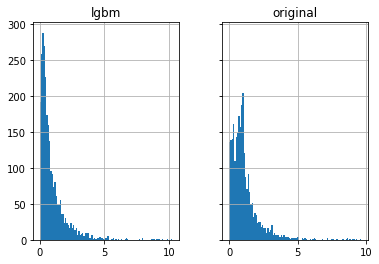

In [115]:
err[err['original'] < 10][['original', 'lgbm']].hist(bins=100, sharey = True)

,original,lgbm
count,286.000000,286.000000
mean,0.958159,0.525740
std,0.026259,0.340671
min,0.900000,0.011899
25%,0.933333,0.312239
50%,0.966667,0.445242
75%,0.983333,0.615064
max,1.000000,1.989579


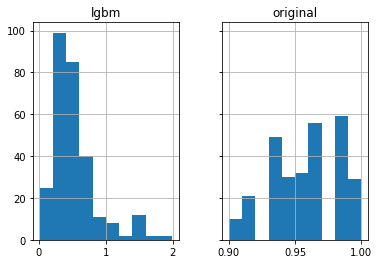

In [119]:
# (0.9, 1.0] interval
err[(err['original'] <=1) & (err['original'] > 0.9)].hist(sharey = True)
err[(err['original'] <=1) & (err['original'] > 0.9)].describe()

In [120]:
# (2.283, 65.767] interval
err[err['original'] > 2.283].describe()

,original,lgbm
count,275.000000,275.000000
mean,3.999515,3.622699
std,4.039642,3.619869
min,2.283333,0.660865
25%,2.641667,2.316250
50%,3.100000,2.936652
75%,4.008333,3.761324
max,54.500000,54.637175
